## X-Ray Abnormality Detection | DenseNet-169, pretrained on ImageNet

> **Antonopoulos Ilias** ( *p3352004* ) <br />
> **Ndoja Silva** ( *p3352017* ) <br />
> **MSc in Data Science, AUEB**

## Table of Contents

- [Data Loading](#Data-Loading)
 * [Create a tensorflow input pipeline for the training data](#Create-a-tensorflow-input-pipeline-for-the-training-data)
- [DenseNet169-architecture,-pretrained-on-ImageNet](#DenseNet169-architecture,-pretrained-on-ImageNet)

In [1]:
import os
import pathlib
import random
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

from utils import (
    clean_up,
    F1Score,
    inspect_df,
    plot_metrics,
    study_oriented_transformation,
)


pd.set_option("max_colwidth", None)
plt.style.use("dark_background")

In [2]:
print(tf.__version__)

2.8.0


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


2022-04-01 21:21:21.616918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 21:21:21.622819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 21:21:21.623000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [5]:
SEED = 99910123

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [6]:
DATASET_DIR = "../data/MURA-v1.1/"

In [7]:
random.choices(glob(os.path.join(DATASET_DIR, "*", "*", "*", "*", "*.png")), k=10)

['../data/MURA-v1.1/train/XR_WRIST/patient08092/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient01064/study1_positive/image1.png',
 '../data/MURA-v1.1/valid/XR_ELBOW/patient11831/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00442/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06289/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient08562/study1_negative/image2.png',
 '../data/MURA-v1.1/train/XR_FINGER/patient04280/study1_negative/image3.png',
 '../data/MURA-v1.1/train/XR_WRIST/patient07018/study1_positive/image1.png',
 '../data/MURA-v1.1/train/XR_ELBOW/patient06000/study1_negative/image1.png',
 '../data/MURA-v1.1/train/XR_SHOULDER/patient00497/study2_negative/image4.png']

So, the data structure is the following:

```

└─train {data subset}
│   └───XR_ELBOW {study type}
│       │  └───patient00011 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
│       │               └───image3.png 
                        └───...
   ...
   

└─valid {data subset}
│   └───XR_HUMERUS {study type}
│       │  └───patient11216 {patient}
│       │         └───study1_negative {study with label}
│       │               └───image1.png {view}
│       │               └───image2.png 
                        └───...
```

In [8]:
image_count = len(list(pathlib.Path(DATASET_DIR).glob("*/*/*/*/*.png")))

print(f"Total PNG images found in dir <{DATASET_DIR}>: {image_count}")

Total PNG images found in dir <../data/MURA-v1.1/>: 40009


We will start by creating a tabular form of the training data (with no actual image files), in order to quickly analyze them. A proper data loader (of the actual image files) will be implemented after that, in a tensorflow-friendly manner.

In [9]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"),
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [10]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [11]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [12]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"),
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [13]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("../data/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [14]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [15]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,../data/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [21]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

Since image directory follows a specific ontological structure (7 upper extremities aka study types) we will shuffle the training dataset beforehand in order to ensure that the validation set will be representable of all study types. 

This is due to the fact that tf.keras `tf.keras.preprocessing.image.ImageDataGenerator` first performs the train-val split and then shuffles per epoch by default.

In [22]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [23]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant",
    cval=0.0,
    validation_split=0.25,
    preprocessing_function=tf.keras.applications.densenet.preprocess_input,
)

In [24]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=8,
    seed=SEED,
    shuffle=True,
    subset="training",
)

Found 27606 validated image filenames belonging to 2 classes.


In [25]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=8,
    seed=SEED,
    shuffle=True,
    subset="validation",
)

Found 9202 validated image filenames belonging to 2 classes.


### DenseNet169 architecture, pretrained on ImageNet

In [26]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

2022-04-01 21:21:23.107448: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 21:21:23.108322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 21:21:23.108494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 21:21:23.108648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
"""
Densenet-169 model from `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.

We will opt for max pooling for feature extraction, since we want to "emphasize" any sharp features on the image
(e.g hardware placed on human body that most definitely suggests abnormality).
"""
densenet = tf.keras.applications.densenet.DenseNet169(
    include_top=False,  # do not include the fully-connected layer at the top of the network
    weights="imagenet",
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    pooling="max",  # pooling mode for feature extraction
    classes=2,
)

In [28]:
def make_densenet_model(
    base_model: tf.keras.applications.densenet.DenseNet201,
) -> tf.keras.Model:

    # freeze base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    # the base model contains batchnorm layer - we want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base model is running in inference mode here.
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(rate=0.2)(x)
    output = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

    return model

In [29]:
model = make_densenet_model(base_model=densenet)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


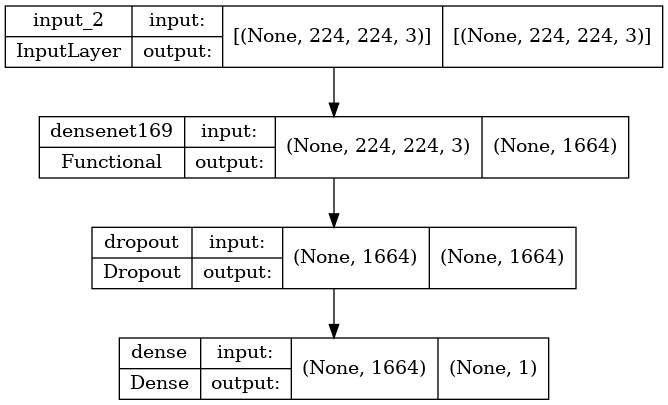

In [31]:
tf.keras.utils.plot_model(
    model,
    to_file="../static/densenet169_pt_imagenet-all-study-types-12644545.png",
    show_shapes=True,
    show_layer_names=True,
)

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_cohen_kappa",
    verbose=1,
    patience=5,
    mode="max",
)

In [33]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_cohen_kappa", factor=0.2, verbose=1, patience=7, min_lr=1e-10
)

In [34]:
history = model.fit(
    trainset,
    epochs=20,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/20


2022-04-01 21:21:34.570331: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-01 21:21:35.555950: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


3451/3451 [==============================] - 441s 125ms/step - loss: 0.7759 - tp: 5798.0000 - fp: 4464.0000 - tn: 11994.0000 - fn: 5350.0000 - binary_acc: 0.6445 - precision: 0.5650 - recall: 0.5201 - f1_score: 0.5416 - roc_auc: 0.6744 - pr_auc: 0.5878 - cohen_kappa: 0.2521 - val_loss: 0.6779 - val_tp: 1125.0000 - val_fp: 304.0000 - val_tn: 5173.0000 - val_fn: 2600.0000 - val_binary_acc: 0.6844 - val_precision: 0.7873 - val_recall: 0.3020 - val_f1_score: 0.4366 - val_roc_auc: 0.7526 - val_pr_auc: 0.6922 - val_cohen_kappa: 0.2735 - lr: 0.0010
Epoch 2/20
3451/3451 [==============================] - 406s 118ms/step - loss: 0.6818 - tp: 6110.0000 - fp: 4037.0000 - tn: 12421.0000 - fn: 5038.0000 - binary_acc: 0.6713 - precision: 0.6021 - recall: 0.5481 - f1_score: 0.5738 - roc_auc: 0.7072 - pr_auc: 0.6333 - cohen_kappa: 0.3072 - val_loss: 0.7226 - val_tp: 3181.0000 - val_fp: 3075.0000 - val_tn: 2402.0000 - val_fn: 544.0000 - val_binary_acc: 0.6067 - val_precision: 0.5085 - val_recall: 0.854

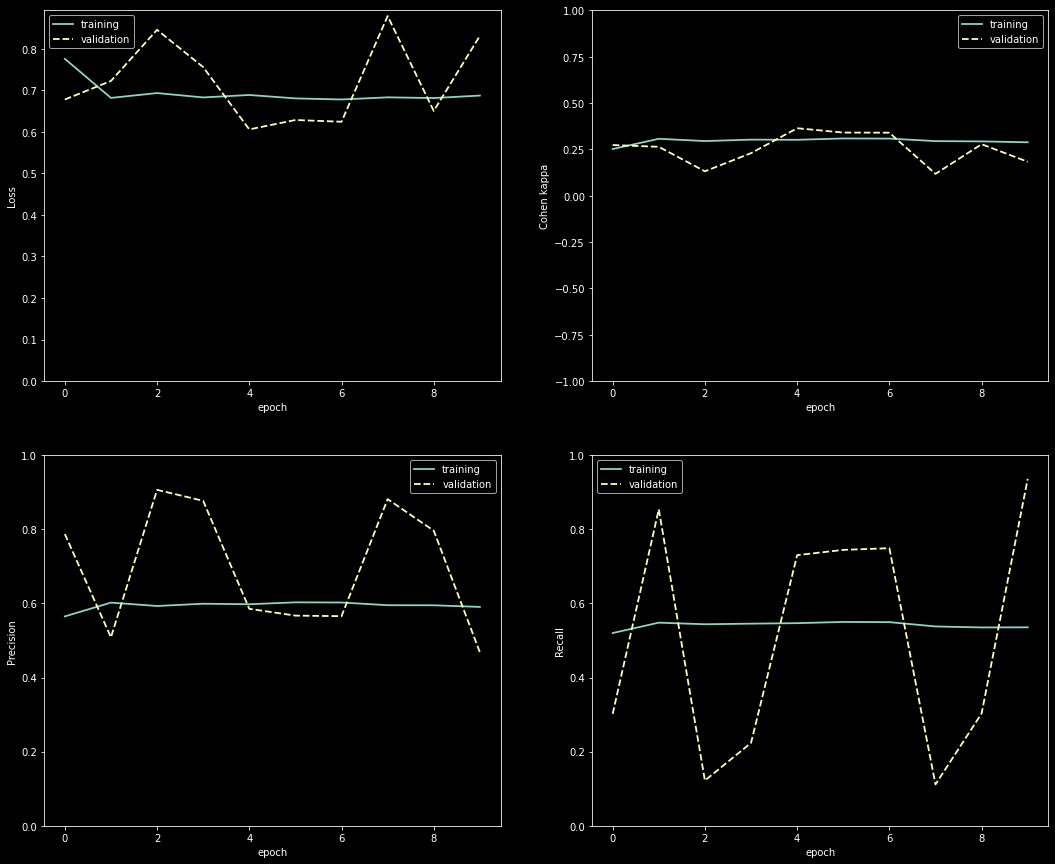

In [35]:
plot_metrics(history)

In [36]:
# model naming convention: {architecture}-{which-study-type?}-{num-parameters}.h5
#
# to load models:
# model = tf.keras.models.load_model(
#     '../models/densenet169_pt_imagenet-all-study-types-12644545.h5',
#     custom_objects={'F1Score': F1Score}
# )
# densenet = tf.keras.models.load_model(
#     '../models/densenet169_base.h5',
# )
model.save("../models/densenet169_pt_imagenet-all-study-types-12644545.h5")
densenet.save("../models/densenet169_base.h5")

In [37]:
# fine-tuning: unfreeze the base model and train the entire model end-to-end with a low learning rate
densenet.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        1e-5
    ),  # we need small learning rate to avoid catastrophic forgetting
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

In [38]:
history = model.fit(
    trainset,
    epochs=10,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
)

Epoch 1/10


2022-04-01 22:29:56.386366: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-01 22:29:56.386402: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.78GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-01 22:29:56.409910: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.79GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-01 22:29:56.409945: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

3451/3451 [==============================] - 1159s 331ms/step - loss: 0.5221 - tp: 9777.0000 - fp: 5981.0000 - tn: 15954.0000 - fn: 5096.0000 - binary_acc: 0.6991 - precision: 0.6204 - recall: 0.6574 - f1_score: 0.6384 - roc_auc: 0.7630 - pr_auc: 0.7113 - cohen_kappa: 0.3810 - val_loss: 0.4981 - val_tp: 2505.0000 - val_fp: 898.0000 - val_tn: 4579.0000 - val_fn: 1220.0000 - val_binary_acc: 0.7698 - val_precision: 0.7361 - val_recall: 0.6725 - val_f1_score: 0.7029 - val_roc_auc: 0.8277 - val_pr_auc: 0.8027 - val_cohen_kappa: 0.5157 - lr: 1.0000e-05
Epoch 2/10
3451/3451 [==============================] - 1134s 329ms/step - loss: 0.4700 - tp: 6828.0000 - fp: 1540.0000 - tn: 14918.0000 - fn: 4320.0000 - binary_acc: 0.7877 - precision: 0.8160 - recall: 0.6125 - f1_score: 0.6997 - roc_auc: 0.8378 - pr_auc: 0.8154 - cohen_kappa: 0.5407 - val_loss: 0.4631 - val_tp: 2226.0000 - val_fp: 409.0000 - val_tn: 5068.0000 - val_fn: 1499.0000 - val_binary_acc: 0.7927 - val_precision: 0.8448 - val_recall:

In [39]:
# model naming convention: {architecture}-{which-study-type?}-{num-parameters}.h5
#
# to load models:
# model = tf.keras.models.load_model(
#     '../models/densenet169_pt_imagenet-all-study-types-12644545.h5',
#     custom_objects={'F1Score': F1Score}
# )
# densenet = tf.keras.models.load_model(
#     '../models/densenet169_base.h5',
# )
model.save("../models/densenet169_pt_imagenet-all-study-types-12644545.h5")
densenet.save("../models/densenet169_base.h5")

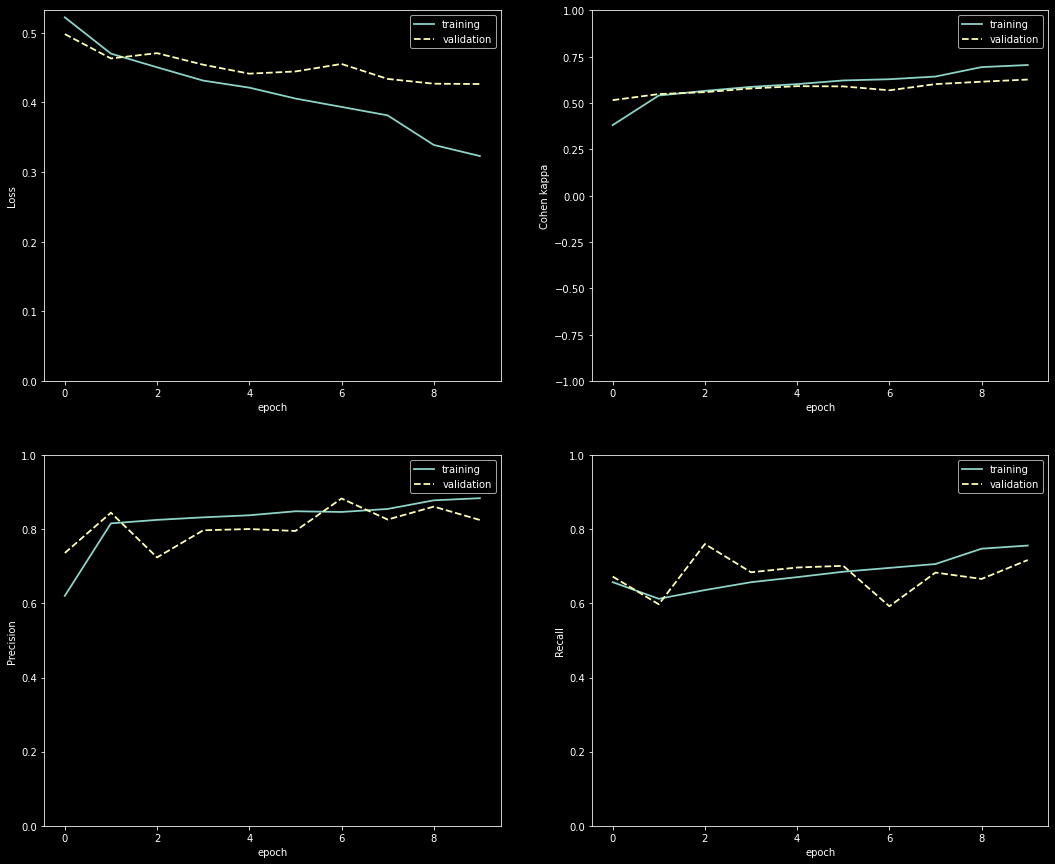

In [40]:
plot_metrics(history)

In [61]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

1151/1151 [==============================] - 93s 79ms/step - loss: 0.4280 - tp: 2667.0000 - fp: 560.0000 - tn: 4917.0000 - fn: 1058.0000 - binary_acc: 0.8242 - precision: 0.8265 - recall: 0.7160 - f1_score: 0.7673 - roc_auc: 0.8778 - pr_auc: 0.8572 - cohen_kappa: 0.6271


In [63]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.427978515625
tp          : 2667.0
fp          : 560.0
tn          : 4917.0
fn          : 1058.0
binary_acc  : 0.8241686820983887
precision   : 0.8264642357826233
recall      : 0.7159731388092041
f1_score    : 0.767261266708374
roc_auc     : 0.8778469562530518
pr_auc      : 0.8572461605072021
cohen_kappa : 0.627137303352356


In [74]:
clean_up(model)
clean_up(densenet)